In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from pandas import read_csv

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import collections
%matplotlib inline

Using TensorFlow backend.
/Users/jocelyn/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jocelyn/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jocelyn/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jocelyn/opt/anaconda3/lib/pytho

In [2]:
# Set up a 'look back' dataset for sequence to label prediction with Keras.

# The LSTM network expects the input data (X) to be provided with a specific
# array structure in the form of: [samples, time steps, features].

def create_dataset(X, Y, **options):
    """Convert an array of X, Y values into a dataset matrix for and LSTM"""
    
    look_back = options.pop('look_back', None)
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i+look_back)]
        dataX.append(a)
        dataY.append(Y[i + look_back - 1])
    return np.array(dataX), np.array(dataY)

# Predictions will be based on look_back minutes of data:
look_back = 30

In [ ]:
Test_path = glob.glob('C:\\Users\\XWANG221\\VolvoData\\ALLCutInTest\\*.csv')

# Randomly created matrix
X_TestData = np.empty((1, 50, 28))
Y_TestData = np.empty((1,))

for f in range(400):
    # print the path of the loading data
    print(Test_path[f].split('\\')[-1])
  
    # The loading data
    CutIn_Test = pd.read_csv(Test_path[f], usecols=['Lat','Long','Lane','Velocity','PosLgt2','PosLgt3','VelLgt1','VelLgt2','VelLgt3','VelLat3','AccLgt1','AccLgt2','AccLgt3','AccLat1','AccLat2','AccLat3','Angle1','Angle2','Angle3','Type1','Type2','Id1','Id2','Lane1','PositionInLane1','PositionInLane2','PositionInLane3','Lead','CutIn'])
    # Fill "NaN" with 10000000
    CutIn_Test.fillna(10000000, inplace=True)
    
    # Extract Y from the loading data
    Y_train_Test = np.array(CutIn_Test['CutIn'].values)
    # Extract X from the loading data
    X_train_Test = np.array(CutIn_Test[['Lat','Long','Lane','Velocity','PosLgt2','PosLgt3','VelLgt1','VelLgt2','VelLgt3','VelLat3','AccLgt1','AccLgt2','AccLgt3','AccLat1','AccLat2','AccLat3','Angle1','Angle2','Angle3','Type1','Type2','Id1','Id2','Lane1','PositionInLane1','PositionInLane2','PositionInLane3','Lead']])

    dimof_output = 1
    dimof_input = X_train_Test.shape[1]

    # Scale/whiten the X data
    scaler = StandardScaler()
    # Do standardization for the loading data X
    X_train_Test = scaler.fit_transform(X_train_Test)
    
    # the final matrix after with the look back
    XTest, YTest = create_dataset(X_train_Test, Y_train_Test, look_back=look_back)
    
    # The maxtrix is appended with the first randomly created matrix
    X_TestData = np.append(X_TestData, XTest, axis=0)
    Y_TestData = np.append(Y_TestData, YTest, axis=0)
    

In [4]:
Train_path = glob.glob('C:\\Users\\XWANG221\\VolvoData\\AllCutInTrain\\*.csv')

# Randomly created matrix
X_all = np.empty((1, 50, 28))
Y_all = np.empty((1,))

for j in range(500):
    
    CutIn = pd.read_csv(Train_path[j], usecols=['Lat','Long','Lane','Velocity','PosLgt2','PosLgt3','VelLgt1','VelLgt2','VelLgt3','VelLat3','AccLgt1','AccLgt2','AccLgt3','AccLat1','AccLat2','AccLat3','Angle1','Angle2','Angle3','Type1','Type2','Id1','Id2','Lane1','PositionInLane1','PositionInLane2','PositionInLane3','Lead','CutIn'])
    CutIn.fillna(10000000, inplace=True)
    
    Y_train = np.array(CutIn['CutIn'].values)
    X_train = np.array(CutIn[['Lat','Long','Lane','Velocity','PosLgt2','PosLgt3','VelLgt1','VelLgt2','VelLgt3','VelLat3','AccLgt1','AccLgt2','AccLgt3','AccLat1','AccLat2','AccLat3','Angle1','Angle2','Angle3','Type1','Type2','Id1','Id2','Lane1','PositionInLane1','PositionInLane2','PositionInLane3','Lead']])
   
    dimof_output = 1
    dimof_input = X_train.shape[1]

    # Scale/whiten the X data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    X, Y = create_dataset(X_train, Y_train, look_back=look_back)
    
    X_all = np.append(X_all, X, axis=0)
    Y_all = np.append(Y_all, Y, axis=0)

In [ ]:
# These sizes need to be divisible by 32 and remove the first randomly created matrix.
Train_size = len(X_all)//64*64 + 1
Test_size = len(X_TestData)//64*64 + 1

Xtest = X_TestData[1:Test_size]
Ytest = Y_TestData[1:Test_size]

Xtrain = X_all[1:Train_size]
Ytrain = Y_all[1:Train_size]

In [ ]:
# Create the LSTM network.
batch_size = 32
dropout = 0.5
num_epoch = 100
earlyStopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
weights = {0:1, 1:1}

In [ ]:
model_CutIn = Sequential()
model_CutIn.add(LSTM(output_dim=20, batch_input_shape=[batch_size, look_back, dimof_input]))
model_CutIn.add(Dropout(dropout))
model_CutIn.add(Dense(30, activation='relu'))
model_CutIn.add(Dropout(dropout))
model_CutIn.add(Dense(dimof_output, init='uniform', activation='sigmoid'))
model_CutIn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model_CutIn.fit(
    Xtrain, Ytrain,
    class_weight=weights,
    validation_data=(Xtest, Ytest),
    callbacks=[earlyStopping],
    shuffle=True,
    nb_epoch=num_epoch, batch_size=batch_size, verbose=1)

print(history.history)

Y_predict = model_CutIn.predict_classes(Xtest, verbose=True)

# Add the prediction in a list
a6 = Y_predict.tolist()
# item[0] of the prediction is the predicted label
a26 = [item[0] for item in a6]
# the true label
b6 = Ytest.tolist()

In [ ]:
nums_predict = [index for index, element in enumerate(a26) if element == 1]
p = sum((list(t) for t in zip(nums_predict, nums_predict[1:]) if t[0]+1 != t[1]), [])
p.insert(0,nums_predict[0])
p.append(nums_predict[-1])

nums_Y = [index for index, element in enumerate(b6) if element == 1]
y = sum((list(t) for t in zip(nums_Y, nums_Y[1:]) if t[0]+1 != t[1]), [])
y.insert(0,nums_Y[0])
y.append(nums_Y[-1])

big=0
small=0
same=0

for i in range(len(y)-1):
    if i % 2 == 0:
        for j in range(len(p)):
            if j % 2 == 0: 

                if (y[i] == p[j]) and (y[i+1] == p[j+1]):
                    same=same+1
                    j=j+2
                
                elif p[j]<=y[i] and p[j+1]>=y[i+1]:
                    big=big+1
                    j=j+2
                        
                elif p[j]>=y[i] and p[j+1]<=y[i+1]:
                    small=small+1
                    j=j+2
                    
                else:
                    j=j+2       
        i=i+2    

Predict = len(p)/2
Y = len(y)/2

def precision(n):
    fp = Predict-n
    prec = n/(n+fp)
    return prec

def recall(n):
    fn = Y-n
    rec = n/(n+fn)
    return rec
    
def conf(f):
    conf95 = []
    for i in range(len(y)):
        if i%2 == 0:
            c951=int(y[i]-f*(y[i+1]-y[i]))
            conf95.append(c951)
            conf95.append(y[i+1])
        
            c9522=y[i]+f*(y[i+1]-y[i])
            if float(c9522).is_integer()==True:
                conf95.append(c9522)
                conf95.append(y[i+1])
            else:
                con952 = int(c9522)+1
                conf95.append(con952)
                conf95.append(y[i+1])
        
            conf95.append(y[i])
            c9533=int(y[i+1]-f*(y[i+1]-y[i]))
            if float(c9533).is_integer()==True:
                conf95.append(c9533)
            else:
                c953 = int(c9533)+1
                conf95.append(c953)
            
            conf95.append(y[i])    
            c9544=y[i+1]+f*(y[i+1]-y[i])
            if float(c9544).is_integer()==True:
                conf95.append(c9544)
            else:
                con954 = int(c9544)+1
                conf95.append(con954)
        i=i+2
    return conf95

def result(rangelist):
    con95=0
    for i in range(len(p)):
        if i%2 == 0:
            for j in range(len(rangelist)-7):
                if j%8==0:
                    if (rangelist[j]<=p[i] and p[i+1]<=rangelist[j+1]) or (rangelist[j+2]<=p[i] and p[i+1]<=rangelist[j+3]) or (rangelist[j+4]<=p[i] and p[i+1]<=rangelist[j+5]) or (rangelist[j+6]<=p[i] and p[i+1]<=rangelist[j+7]):       
                        con95=con95+1
                        j=j+8
                    else:
                        j=j+8
            i=i+2
    return con95   
    
con95 = result(conf(0.05))
con90 = result(conf(0.1))          
con85 = result(conf(0.15))            
con80 = result(conf(0.2))

In [ ]:
print("Predict:", Predict, "-", "True:", Y)   
print("big:",big, "-", "precision:", precision(big), "-", "recall:", recall(big))  
print("small:",small, "-", "precision:", precision(small), "-", "recall:", recall(small)) 
print("same:",same, "-", "precision:", precision(same), "-", "recall:", recall(same)) 
print("con95:",con95, "-", "precision:", precision(con95), "-", "recall:", recall(con95))  
print("con90:",con90, "-", "precision:", precision(con90), "-", "recall:", recall(con90)) 
print("con85:",con85, "-", "precision:", precision(con85), "-", "recall:", recall(con85)) 
print("con80:",con80, "-", "precision:", precision(con80), "-", "recall:", recall(con80))

# more 500

In [25]:
X_MoreTrainData = np.empty((1, 50, 28))
Y_MoreTrainData = np.empty((1,))

for j in range(500,1000):
    
    CutIn_more = pd.read_csv(Train_path[j], usecols=['Lat','Long','Lane','Velocity','PosLgt2','PosLgt3','VelLgt1','VelLgt2','VelLgt3','VelLat3','AccLgt1','AccLgt2','AccLgt3','AccLat1','AccLat2','AccLat3','Angle1','Angle2','Angle3','Type1','Type2','Id1','Id2','Lane1','PositionInLane1','PositionInLane2','PositionInLane3','Lead','CutIn'])
    if CutIn_more.shape[0] <= 50:
        pass
    else:
        CutIn_more.fillna(10000000, inplace=True)
    
        Y_train_more = np.array(CutIn_more['CutIn'].values)
        X_train_more = np.array(CutIn_more[['Lat','Long','Lane','Velocity','PosLgt2','PosLgt3','VelLgt1','VelLgt2','VelLgt3','VelLat3','AccLgt1','AccLgt2','AccLgt3','AccLat1','AccLat2','AccLat3','Angle1','Angle2','Angle3','Type1','Type2','Id1','Id2','Lane1','PositionInLane1','PositionInLane2','PositionInLane3','Lead']])

        dimof_output = 1
        dimof_input = X_train_more.shape[1]

        scaler = StandardScaler()
        X_train_more = scaler.fit_transform(X_train_more)
    
        X_more, Y_more = create_dataset(X_train_more, Y_train_more, look_back=look_back)
    
        X_MoreTrainData = np.append(X_MoreTrainData, X_more, axis=0)
        Y_MoreTrainData = np.append(Y_MoreTrainData, Y_more, axis=0)

In [191]:
# Added_size need to be divisible by 32 and remove the first randomly created matrix.
Added_size = len(X_MoreTrainData)//64*64+1

X_MoreTrainData = X_MoreTrainData[1:Added_size]
Y_MoreTrainData = Y_MoreTrainData[1:Added_size]

Xtrain = np.append(Xtrain, X_MoreTrainData, axis=0)
Ytrain = np.append(Ytrain, Y_MoreTrainData, axis=0)

In [8]:
model_CutIn = Sequential()
model_CutIn.add(LSTM(output_dim=20, batch_input_shape=[batch_size, look_back, dimof_input]))
model_CutIn.add(Dropout(dropout))
model_CutIn.add(Dense(30, activation='relu'))
model_CutIn.add(Dropout(dropout))
model_CutIn.add(Dense(dimof_output, init='uniform', activation='sigmoid'))
model_CutIn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model_CutIn.fit(
    Xtrain, Ytrain,
    class_weight=weights,
    validation_data=(Xtest, Ytest),
    callbacks=[earlyStopping],
    shuffle=True,
    nb_epoch=num_epoch, batch_size=batch_size, verbose=1)

print(history.history)

Y_predict = model_CutIn.predict_classes(Xtest, verbose=True)

# Add the prediction in a list
a6 = Y_predict.tolist()
# item[0] of the prediction is the predicted label
a26 = [item[0] for item in a6]
# the true label
b6 = Ytest.tolist()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\XWANG221\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=[32, 50, 2..., units=20)`
  
C:\Users\XWANG221\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  
C:\Users\XWANG221\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Instructions for updating:
Use tf.cast instead.
Train on 35968 samples, validate on 27840 samples
Epoch 1/100
35968/35968 [==============================] - 19s 524us/step - loss: 0.5835 - accuracy: 0.6832 - val_loss: 0.5880 - val_accuracy: 0.7031
Epoch 2/100
35968/35968 [==============================] - 19s 535us/step - loss: 0.4345 - accuracy: 0.8057 - val_loss: 0.5829 - val_accuracy: 0.7338
Epoch 3/100
35968/35968 [==============================] - 19s 515us/step - loss: 0.3803 - accuracy: 0.8411 - val_loss: 0.5383 - val_accuracy: 0.7571
Epoch 4/100
35968/35968 [==============================] - 19s 516us/step - loss: 0.3563 - accuracy: 0.8506 - val_loss: 0.5522 - val_accuracy: 0.7688
{'val_loss': [0.587972610182632, 0.5828519457212553, 0.5382926730139331, 0.5521831452589611], 'val_accuracy': [0.703125, 0.7338002920150757, 0.7571479678153992, 0.7688218355178833], 'loss': [0.5835399936049435, 0.43450437873283737, 0.3802782566787085, 0.3563428303472088], 'accuracy': [0.6831628, 0.805

In [10]:
nums_predict = [index for index, element in enumerate(a26) if element == 1]
p = sum((list(t) for t in zip(nums_predict, nums_predict[1:]) if t[0]+1 != t[1]), [])
p.insert(0,nums_predict[0])
p.append(nums_predict[-1])

nums_Y = [index for index, element in enumerate(b6) if element == 1]
y = sum((list(t) for t in zip(nums_Y, nums_Y[1:]) if t[0]+1 != t[1]), [])
y.insert(0,nums_Y[0])
y.append(nums_Y[-1])

big=0
small=0
same=0

for i in range(len(y)-1):
    if i % 2 == 0:
        for j in range(len(p)):
            if j % 2 == 0: 

                if (y[i] == p[j]) and (y[i+1] == p[j+1]):
                    same=same+1
                    j=j+2
                
                elif p[j]<=y[i] and p[j+1]>=y[i+1]:
                    big=big+1
                    j=j+2
                        
                elif p[j]>=y[i] and p[j+1]<=y[i+1]:
                    small=small+1
                    j=j+2
                    
                else:
                    j=j+2       
        i=i+2    

Predict = len(p)/2
Y = len(y)/2

def precision(n):
    fp = Predict-n
    prec = n/(n+fp)
    return prec

def recall(n):
    fn = Y-n
    rec = n/(n+fn)
    return rec
    
def conf(f):
    conf95 = []
    for i in range(len(y)):
        if i%2 == 0:
            c951=int(y[i]-f*(y[i+1]-y[i]))
            conf95.append(c951)
            conf95.append(y[i+1])
        
            c9522=y[i]+f*(y[i+1]-y[i])
            if float(c9522).is_integer()==True:
                conf95.append(c9522)
                conf95.append(y[i+1])
            else:
                con952 = int(c9522)+1
                conf95.append(con952)
                conf95.append(y[i+1])
        
            conf95.append(y[i])
            c9533=int(y[i+1]-f*(y[i+1]-y[i]))
            if float(c9533).is_integer()==True:
                conf95.append(c9533)
            else:
                c953 = int(c9533)+1
                conf95.append(c953)
            
            conf95.append(y[i])    
            c9544=y[i+1]+f*(y[i+1]-y[i])
            if float(c9544).is_integer()==True:
                conf95.append(c9544)
            else:
                con954 = int(c9544)+1
                conf95.append(con954)
        i=i+2
    return conf95

def result(rangelist):
    con95=0
    for i in range(len(p)):
        if i%2 == 0:
            for j in range(len(rangelist)-7):
                if j%8==0:
                    if (rangelist[j]<=p[i] and p[i+1]<=rangelist[j+1]) or (rangelist[j+2]<=p[i] and p[i+1]<=rangelist[j+3]) or (rangelist[j+4]<=p[i] and p[i+1]<=rangelist[j+5]) or (rangelist[j+6]<=p[i] and p[i+1]<=rangelist[j+7]):       
                        con95=con95+1
                        j=j+8
                    else:
                        j=j+8
            i=i+2
    return con95   
    
con95 = result(conf(0.05))
con90 = result(conf(0.1))          
con85 = result(conf(0.15))            
con80 = result(conf(0.2))

In [11]:
print("Predict:", Predict, "-", "True:", Y)   
print("big:",big, "-", "precision:", precision(big), "-", "recall:", recall(big))  
print("small:",small, "-", "precision:", precision(small), "-", "recall:", recall(small)) 
print("same:",same, "-", "precision:", precision(same), "-", "recall:", recall(same)) 
print("con95:",con95, "-", "precision:", precision(con95), "-", "recall:", recall(con95))  
print("con90:",con90, "-", "precision:", precision(con90), "-", "recall:", recall(con90)) 
print("con85:",con85, "-", "precision:", precision(con85), "-", "recall:", recall(con85)) 
print("con80:",con80, "-", "precision:", precision(con80), "-", "recall:", recall(con80))

Predict: 420.0 - True: 422.0
big: 204 - precision: 0.4857142857142857 - recall: 0.4834123222748815
small: 67 - precision: 0.1595238095238095 - recall: 0.15876777251184834
same: 0 - precision: 0.0 - recall: 0.0
con95: 94 - precision: 0.22380952380952382 - recall: 0.22274881516587677
con90: 117 - precision: 0.2785714285714286 - recall: 0.2772511848341232
con85: 143 - precision: 0.3404761904761905 - recall: 0.33886255924170616
con80: 154 - precision: 0.36666666666666664 - recall: 0.36492890995260663


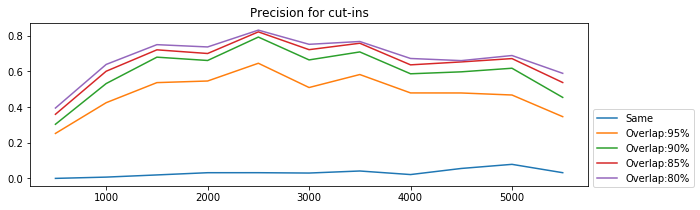

In [3]:
same_P = [0, 0.007159904534606206 , 0.01937046004842615 ,0.031862745098039214  ,0.03194103194103194  ,0.03  ,0.041463414634146344  ,0.021479713603818614 ,0.05569007263922518 ,0.07881773399014778 ,0.03194103194103194 ]
con95_P = [0.2523364485981308 ,0.42482100238663484 ,0.5375302663438256 ,0.5465686274509803  ,0.6461916461916462  ,0.51  , 0.5829268292682926 ,0.4797136038186158 ,0.4794188861985472 ,0.46798029556650245 , 0.3464373464373464]
con90_P = [0.3037383177570093 , 0.5322195704057279 ,0.6803874092009685  ,0.6617647058823529  ,0.7931873479318735  ,0.665  ,0.7097560975609756  ,0.5871121718377088 ,0.5980629539951574 ,0.6182266009852216 , 0.45454545454545453]
con85_P = [0.3598130841121495 , 0.6014319809069213 , 0.7215496368038741 , 0.7009803921568627 , 0.8223844282238443 , 0.7225 ,0.7585365853658537  , 0.6372315035799523, 0.6537530266343826, 0.6724137931034483,0.538083538083538  ]
con80_P = [0.39485981308411217 ,0.639618138424821 , 0.7506053268765133 ,0.7377450980392157  ,0.8321167883211679  ,0.7525  ,0.7682926829268293  , 0.6730310262529833, 0.6610169491525424,0.6896551724137931 ,0.5896805896805897 ]


x = [500, 1000, 1500, 2000,2500,3000,3500,4000,4500,5000,5500 ]

f, ax = plt.subplots(figsize=(10,3))
plt.plot(x, same_P)
plt.plot(x, con95_P)
plt.plot(x, con90_P)
plt.plot(x, con85_P)
plt.plot(x, con80_P)

plt.legend(['Same', 'Overlap:95%', 'Overlap:90%', 'Overlap:85%', 'Overlap:80%'], loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Precision for cut-ins')
plt.show()


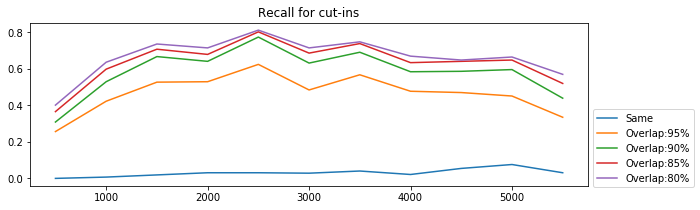

In [4]:
same_R = [0,0.0071090047393364926, 0.018957345971563982,0.030805687203791468 ,0.030805687203791468 , 0.02843601895734597, 0.04028436018957346,0.02132701421800948 , 0.054502369668246446,0.07582938388625593 ,0.030805687203791468]
con95_R = [0.2559241706161137,0.4218009478672986,0.5260663507109005 , 0.5284360189573459, 0.6232227488151659,0.4834123222748815 ,0.566350710900474 , 0.476303317535545,0.46919431279620855 , 0.45023696682464454, 0.3341232227488152]
con90_R = [0.3080568720379147,0.5284360189573459, 0.6658767772511849, 0.6398104265402843, 0.7725118483412322, 0.6303317535545023,0.6895734597156398 , 0.5829383886255924,0.5853080568720379 , 0.5947867298578199,0.43838862559241704]
con85_R = [0.36492890995260663, 0.5971563981042654, 0.7061611374407583,0.6777251184834123 ,0.8009478672985783 ,0.6848341232227488 ,0.7369668246445498 ,0.6327014218009479 , 0.6398104265402843,0.6469194312796208 ,0.518957345971564  ]
con80_R = [0.4004739336492891, 0.6350710900473934, 0.7345971563981043,0.7132701421800948 ,0.8104265402843602 ,0.7132701421800948 , 0.7464454976303317,0.6682464454976303 ,0.6469194312796208 , 0.6635071090047393, 0.5687203791469194 ]

f, ax = plt.subplots(figsize=(10,3))
plt.plot(x, same_R)
plt.plot(x, con95_R)
plt.plot(x, con90_R)
plt.plot(x, con85_R)
plt.plot(x, con80_R)

plt.legend(['Same', 'Overlap:95%', 'Overlap:90%', 'Overlap:85%', 'Overlap:80%'], loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Recall for cut-ins')
plt.show()


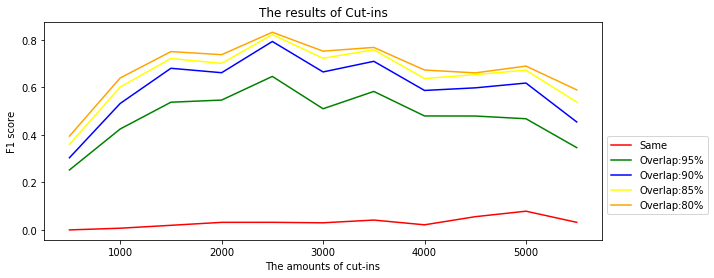

In [6]:
f, ax = plt.subplots(figsize=(10,4))
plt.plot(x, same_P, color='red')
plt.plot(x, con95_P, color='green')
plt.plot(x, con90_P, color='blue')
plt.plot(x, con85_P, color='yellow')
plt.plot(x, con80_P, color='orange')

#plt.plot(x, same_R, color='red')
#plt.plot(x, con95_R, color='green')
#plt.plot(x, con90_R, color='blue')
#plt.plot(x, con85_R, color='yellow')
#plt.plot(x, con80_R, color='orange')

plt.legend(['Same', 'Overlap:95%', 'Overlap:90%', 'Overlap:85%', 'Overlap:80%'], loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('The results of Cut-ins')
plt.xlabel('The amounts of cut-ins')
plt.ylabel('F1 score')
plt.show()
